# Task 1. Virtual Detector Framework

### A. Define detector geometries

In [71]:
# Generate masks in reciprocal space (kx, ky grid)
import numpy as np

def make_coordinate_grid(nx, ny, center=None):
    
    if center is None:
        cx, cy = nx//2, ny//2
    else:
        cx, cy = center

    x = np.arange(nx) - cx
    y = np.arange(ny) - cy
    X, Y = np.meshgrid(x, y, indexing='ij')
    R = np.sqrt(X**2 + Y**2)
    return X, Y, R

In [72]:
# Define Bright Field (BF) detector
def bright_field_detector(shape, radius, center=None):

    nx, ny = shape
    X, Y, R = make_coordinate_grid(nx, ny, center)
    mask = R <= radius
    return mask.astype(float)

In [73]:
# Define Annular Dark Field (ADF) detector
def annular_dark_field_detector(shape, r_inner, r_outer, center=None):

    if r_inner >= r_outer:
        raise ValueError("r_inner must be < r_outer")

    nx, ny = shape
    X, Y, R = make_coordinate_grid(nx, ny, center)
    mask = (R >= r_inner) & (R <= r_outer)
    return mask.astype(float)

In [74]:
# Define Custom detector
def custom_detector(mask):

    return mask.astype(float)

### B. Apply detectors to 4D-STEM data

In [75]:
# Apply chosen virtual detector to dataset
def apply_virtual_detector(data4d, detector_mask):

        sx, sy, kx, ky = data4d.shape

        if detector_mask.shape != (kx, ky):
            raise ValueError("Detector mask shape does not match diffraction pattern shape")

        virtual_image = np.zeros((sx, sy))

        for i in range(sx):
            for j in range(sy): 
                dp = data4d[i, j]
                virtual_image[i, j] = np.sum(dp * detector_mask)

        return virtual_image

### C. Safety Checks

In [78]:
# Validation proper mask application
def validate_detector(mask, shape):

    nx, ny = shape

    if mask.shape != (nx, ny):
        raise ValueError("Detector mask exceeds detector FOV")

    if np.sum(mask) == 0:
        raise ValueError("Detector mask is empty")

    return True

### D. Demonstration with Si-Au 4D-STEM Diffraction Dataset

#### Load, inspect, and extract data

In [82]:
# Load 4D-STEM data
import py4DSTEM

filepath = "Diffraction Si_Au_Calib.dm4"
dc = py4DSTEM.io.import_file(filepath)

print("Calibration dataset successfully loaded!")

Calibration dataset successfully loaded!


In [83]:
# Inspect 4D-STEM data upon import
print(type(dc))
print("Dataset shape:", dc.data.shape)
print(dc.calibration)

<class 'py4DSTEM.datacube.datacube.DataCube'>
Dataset shape: (20, 20, 256, 256)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.026740015
             R_pixel_size:    0.0020393706
             Q_pixel_units:   A^-1
             R_pixel_units:   µm
             QR_flip:         False
)


In [84]:
# Extract raw 4D array
data4d = dc.data

# Confirm dimensions
sx, sy, kx, ky = data4d.shape
print("Scan shape:", (sx, sy))
print("Diffraction pattern shape:", (kx, ky))

Scan shape: (20, 20)
Diffraction pattern shape: (256, 256)


#### Define additional functions

In [85]:
def estimate_beam_center_com(diffraction_pattern):
    dp = diffraction_pattern.astype(np.float64)

    ny, nx = dp.shape   # IMPORTANT: py4DSTEM often uses (y, x)
    y = np.arange(ny)
    x = np.arange(nx)
    X, Y = np.meshgrid(x, y)

    total_intensity = np.sum(dp)

    cx = np.sum(X * dp) / total_intensity
    cy = np.sum(Y * dp) / total_intensity

    return int(cx), int(cy)

avg_dp = np.mean(data4d, axis=(0, 1))

beam_cx, beam_cy = estimate_beam_center_com(avg_dp)
print("Beam center (CoM):", (beam_cx, beam_cy))

Beam center (CoM): (130, 124)


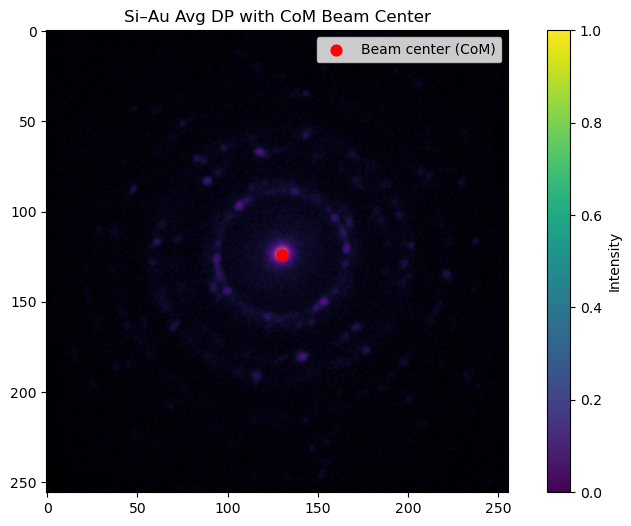

In [86]:
# Sanity check visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.imshow(np.sqrt(avg_dp), cmap="magma")
plt.scatter(beam_cx, beam_cy, c='red', s=60, label='Beam center (CoM)')
plt.title("Si–Au Avg DP with CoM Beam Center")
plt.colorbar(label="Intensity")
plt.legend()
plt.show()

In [87]:
# Build reciprocal-space coordinate grid
def make_reciprocal_grid(shape, center):

    ny, nx = shape
    cy, cx = center[1], center[0]

    y = np.arange(ny) - cy
    x = np.arange(nx) - cx
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    return X, Y, R

X, Y, R = make_reciprocal_grid(avg_dp.shape, (beam_cx, beam_cy))

In [88]:
# Define BF and ADF detectors
bf_radius = 10
adf_inner = 25
adf_outer = 60

bf_mask = (R <= bf_radius).astype(float)
adf_mask = ((R >= adf_inner) & (R <= adf_outer)).astype(float)

In [89]:
# Detector validation
def validate_detector(mask, shape):
    if mask.shape != shape:
        raise ValueError("Detector mask exceeds reciprocal-space field of view")
    if np.sum(mask) == 0:
        raise ValueError("Detector mask is empty")
    return True

validate_detector(bf_mask, avg_dp.shape)
validate_detector(adf_mask, avg_dp.shape)

True

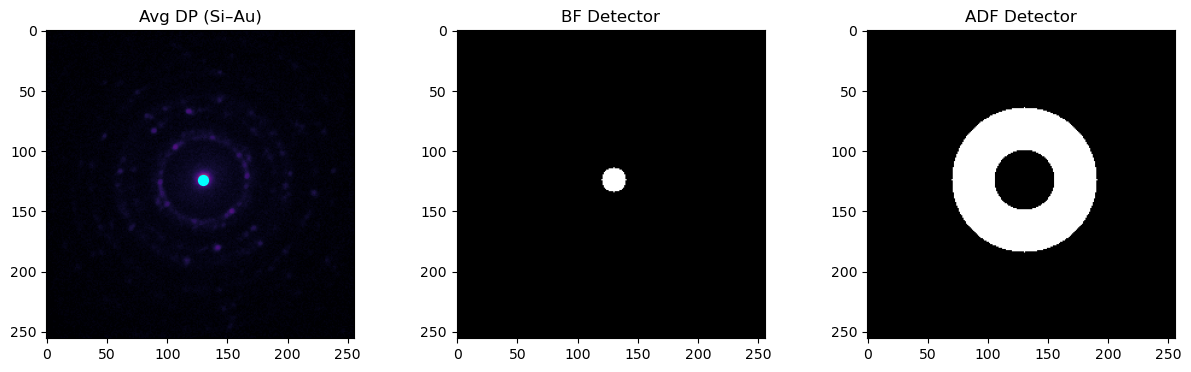

In [90]:
# Visualize detector geometry
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.imshow(np.sqrt(avg_dp), cmap="magma")
plt.scatter(beam_cx, beam_cy, c='cyan', s=50)
plt.title("Avg DP (Si–Au)")

plt.subplot(1,3,2)
plt.imshow(bf_mask, cmap="gray")
plt.title("BF Detector")

plt.subplot(1,3,3)
plt.imshow(adf_mask, cmap="gray")
plt.title("ADF Detector")

plt.show()

In [91]:
# Apply detectors to full 4D dataset
def apply_virtual_detector(data4d, detector_mask):
    sx, sy, ny, nx = data4d.shape
    virtual_image = np.zeros((sx, sy))

    for i in range(sx):
        for j in range(sy):
            dp = data4d[i, j]
            virtual_image[i, j] = np.sum(dp * detector_mask)

    return virtual_image

bf_image = apply_virtual_detector(data4d, bf_mask)
adf_image = apply_virtual_detector(data4d, adf_mask)

In [92]:
# Compute real-space intensity image
def compute_real_space_intensity(data4d):
    sx, sy, ny, nx = data4d.shape
    real_space = np.zeros((sx, sy))

    for i in range(sx):
        for j in range(sy):
            real_space[i, j] = np.sum(data4d[i, j])

    return real_space

real_space_img = compute_real_space_intensity(data4d)

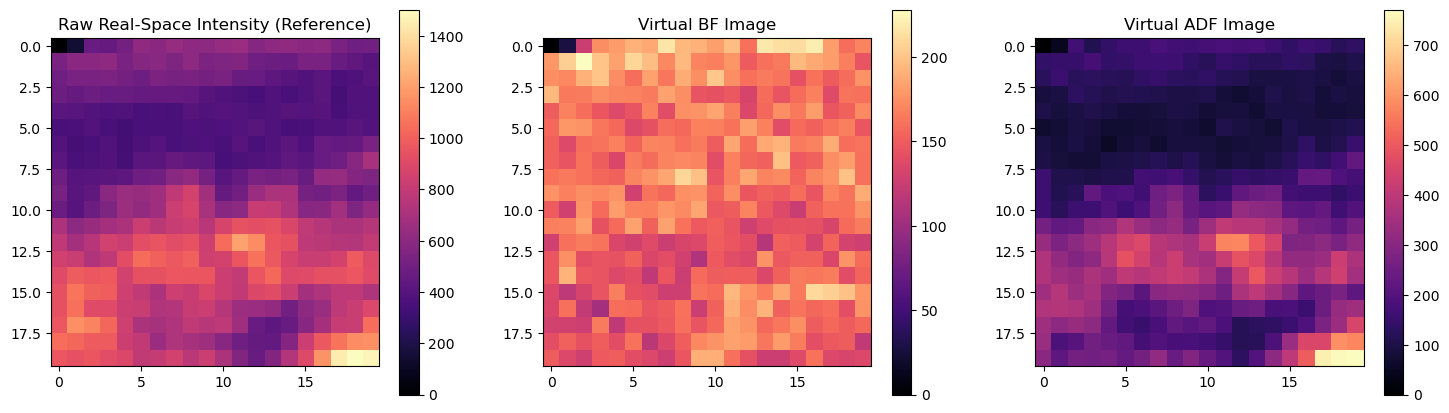

In [94]:
# Visualize raw and virtual images
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.imshow(real_space_img, cmap="magma")
plt.title("Raw Real-Space Intensity (Reference)")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(bf_image, cmap="magma")
plt.title("Virtual BF Image")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(adf_image, cmap="magma")
plt.title("Virtual ADF Image")
plt.colorbar()

plt.show()

# Task 2. Virtual Detector Framework

### Total scattered intensity + CoM (per diffraction pattern)

In [95]:
# Total intensity
def total_scattered_intensity(dp): 

    return np.sum(dp)

In [96]:
# Center of Mass (per diffraction pattern)
def center_of_mass(dp):
    dp = dp.astype(np.float64)

    total = np.sum(dp)

    # Guard against empty / invalid diffraction patterns
    if total <= 0 or not np.isfinite(total):
        return np.nan, np.nan

    ny, nx = dp.shape
    y = np.arange(ny)
    x = np.arange(nx)
    X, Y = np.meshgrid(x, y)

    cx = np.sum(X * dp) / total
    cy = np.sum(Y * dp) / total

    return cx, cy

In [97]:
# Apply across full 4D dataset
def compute_intensity_and_com(data4d):
    sx, sy, ny, nx = data4d.shape

    intensity_map = np.zeros((sx, sy))
    com_x = np.zeros((sx, sy))
    com_y = np.zeros((sx, sy))

    for i in range(sx):
        for j in range(sy):
            dp = data4d[i, j]

            intensity_map[i, j] = total_scattered_intensity(dp)

            cx, cy = center_of_mass(dp)
            com_x[i, j] = cx
            com_y[i, j] = cy

    return intensity_map, com_x, com_y

### B. Radial intensity profile

In [98]:
# Radial intensity profile
def radial_intensity_profile(dp, R, bin_width=1.0):
    """
    Compute radial intensity profile for one diffraction pattern.
    R = radial distance grid (same shape as dp)
    """
    r_flat = R.flatten()
    i_flat = dp.flatten()

    r_max = r_flat.max()
    bins = np.arange(0, r_max + bin_width, bin_width)

    radial_sum = np.zeros(len(bins)-1)
    counts = np.zeros(len(bins)-1)

    for k in range(len(bins)-1):
        mask = (r_flat >= bins[k]) & (r_flat < bins[k+1])
        radial_sum[k] = np.sum(i_flat[mask])
        counts[k] = np.sum(mask)

    radial_avg = radial_sum / np.maximum(counts, 1)

    r_centers = 0.5 * (bins[:-1] + bins[1:])

    return r_centers, radial_avg

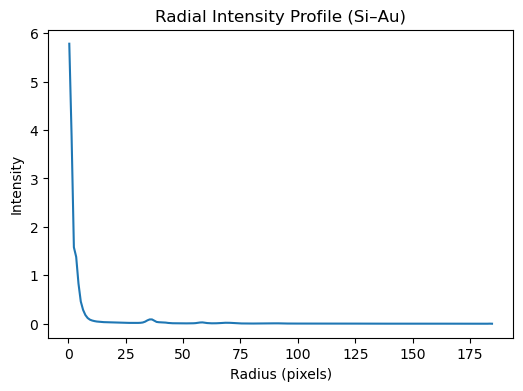

In [99]:
# Example usage on Si-Au 4D-STEM data

r_vals, radial_profile = radial_intensity_profile(avg_dp, R, bin_width=1)

plt.figure(figsize=(6,4))
plt.plot(r_vals, radial_profile)
plt.xlabel("Radius (pixels)")
plt.ylabel("Intensity")
plt.title("Radial Intensity Profile (Si–Au)")
plt.show()

### C. Reciprocal-space calibration (pixels to A^-1 or mrad)

In [100]:
# Extract calibration from metadata (if available)

def get_reciprocal_calibration(dc):

    try: 
        k_unit = dc.axes[-1].units
        k_scale = dc.axes[-1].scale
        return k_scale, k_unit
    except: 
        return None, None

In [101]:
# Manual calibration fallback (control dataset)
def pixel_to_reciprocal(pixel_radius, calibration_factor):

    return pixel_radius * calibration_factor

calibration_factor = dc.Q_pixel_size

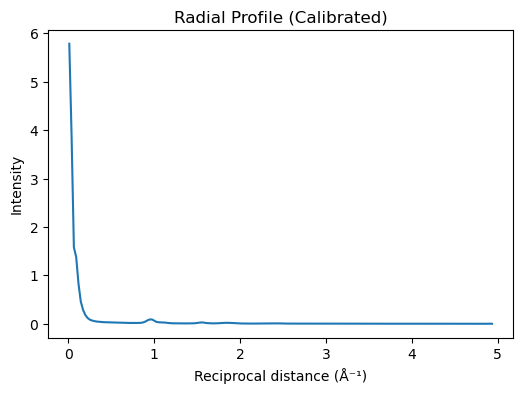

In [102]:
# Convert radial profile to physical units
r_phys = r_vals * calibration_factor

plt.figure(figsize=(6,4))
plt.plot(r_phys, radial_profile)
plt.xlabel("Reciprocal distance (Å⁻¹)")
plt.ylabel("Intensity")
plt.title("Radial Profile (Calibrated)")
plt.show()

In [103]:
# Example usage with Si-Au 4D-STEM dataset
type(dc)
print(dc.calibration)

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.026740015
             R_pixel_size:    0.0020393706
             Q_pixel_units:   A^-1
             R_pixel_units:   µm
             QR_flip:         False
)


In [104]:
calibration_factor = dc.Q_pixel_size
calibration_unit = dc.Q_pixel_units

print("Calibration factor:", calibration_factor)
print("Unit:", calibration_unit)

Calibration factor: 0.026740015
Unit: A^-1


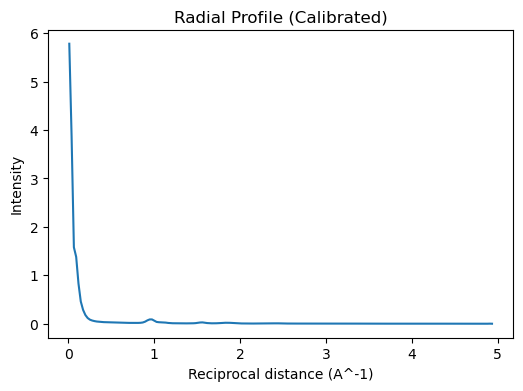

In [105]:
r_phys = r_vals * calibration_factor

plt.figure(figsize=(6,4))
plt.plot(r_phys, radial_profile)
plt.xlabel(f"Reciprocal distance ({calibration_unit})")
plt.ylabel("Intensity")
plt.title("Radial Profile (Calibrated)")
plt.show()

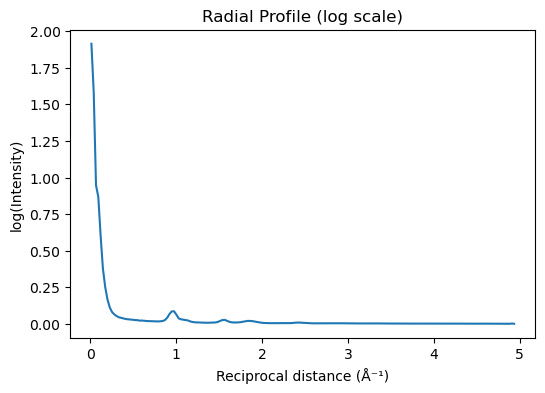

In [106]:
plt.figure(figsize=(6,4))
plt.plot(r_phys, np.log(radial_profile + 1))
plt.xlabel("Reciprocal distance (Å⁻¹)")
plt.ylabel("log(Intensity)")
plt.title("Radial Profile (log scale)")
plt.show()

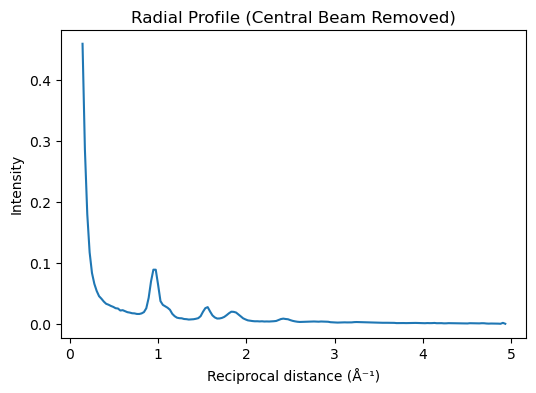

In [107]:
mask = r_vals > 5   # exclude central few pixels
plt.figure(figsize=(6,4))
plt.plot(r_phys[mask], radial_profile[mask])
plt.xlabel("Reciprocal distance (Å⁻¹)")
plt.ylabel("Intensity")
plt.title("Radial Profile (Central Beam Removed)")
plt.show()

# Task 3. The Analysis Pipeline

### A. Add axis normalization (based on Si/SiGe dataset exploration)

In [108]:
def normalize_datacube_axes(data4d):
    """
    Ensure data is ordered as:
    (scan_x, scan_y, ky, kx)
    Works even if input is permuted (e.g. reciprocal/real swapped).
    """
    shape = data4d.shape
    if len(shape) != 4:
        raise ValueError(f"Expected 4D data, got shape {shape}")

    # Heuristic: diffraction dimensions are usually the two largest (e.g., 256x256)
    sorted_dims = sorted(enumerate(shape), key=lambda x: x[1], reverse=True)
    diff_axes = [sorted_dims[0][0], sorted_dims[1][0]]
    scan_axes = [i for i in range(4) if i not in diff_axes]

    new_order = scan_axes + diff_axes
    normalized = np.transpose(data4d, new_order)

    return normalized, new_order

### B. Add additional callibration/metadata extraction

In [109]:
def extract_calibration_and_metadata(dc=None, manual=None, verbose=True):
    meta = {
        "reciprocal_scale": None,
        "reciprocal_unit": None,
        "scan_step_nm": None,
        "detector_pixel_size": None,
        "camera_length": None,
        "source": "none"
    }

    # Try your known-good Si–Au path
    if dc is not None:
        try:
            if verbose and hasattr(dc, "calibration"):
                print("dc.calibration:", dc.calibration)

            if hasattr(dc, "Q_pixel_size"):
                meta["reciprocal_scale"] = dc.Q_pixel_size
            if hasattr(dc, "Q_pixel_units"):
                meta["reciprocal_unit"] = dc.Q_pixel_units

            if meta["reciprocal_scale"] is not None:
                meta["source"] = "dc.Q_pixel_size/Q_pixel_units"
        except Exception as e:
            if verbose:
                print("Calibration extraction failed:", repr(e))

    # Manual fallback (for Si/SiGe where py4DSTEM import is empty)
    if manual is not None:
        for k, v in manual.items():
            if v is not None:
                meta[k] = v
        if meta["source"] == "none":
            meta["source"] = "manual"

    # Final fallback to pixels
    if meta["reciprocal_scale"] is None:
        meta["reciprocal_scale"] = 1.0
        meta["reciprocal_unit"] = "pixels"
        if meta["source"] == "none":
            meta["source"] = "default_pixels"

    if verbose:
        print("Calibration:", meta["reciprocal_scale"], meta["reciprocal_unit"], f"(source: {meta['source']})")

    return meta

### C. Write the pipeline

In [110]:
def run_pipeline(
    data4d,
    detectors,                 # dict: {"BF": bf_mask, "ADF": adf_mask, ...}
    dc=None,                   # optional: py4DSTEM datacube
    manual_calibration=None,   # optional: dict fallback
    compute_radial=True,
    verbose=True
):
    results = {}

    # 1) Normalize axes (handles permuted datasets)
    data4d_norm, axis_order = normalize_datacube_axes(data4d)
    sx, sy, ny, nx = data4d_norm.shape

    if verbose:
        print("Axis order used:", axis_order)
        print("Normalized shape:", data4d_norm.shape)

    # 2) Extract calibration + metadata with fallbacks
    meta = extract_calibration_and_metadata(dc=dc, manual=manual_calibration, verbose=verbose)
    results["metadata"] = meta

    # 3) Apply virtual detectors (multiple in one run)
    virtual_images = {}
    dp_shape = (ny, nx)

    for name, mask in detectors.items():
        validate_detector(mask, dp_shape)
        virtual_images[name] = apply_virtual_detector(data4d_norm, mask)

    results["virtual_images"] = virtual_images

    # 4) Diffraction statistics across scan
    intensity_map, com_x, com_y = compute_intensity_and_com(data4d_norm)
    results["metrics"] = {
        "total_intensity": intensity_map,
        "com_x": com_x,
        "com_y": com_y
    }

    # 5) Radial profile (on average DP; minimal but rubric-compliant)
    if compute_radial:
        avg_dp = np.mean(data4d_norm, axis=(0, 1))
        beam_center = estimate_beam_center_com(avg_dp)

        # Uses your existing reciprocal grid function
        X, Y, R = make_reciprocal_grid(avg_dp.shape, beam_center)

        r_vals, radial_profile = radial_intensity_profile(avg_dp, R, bin_width=1.0)

        r_phys = r_vals * meta["reciprocal_scale"]

        results["radial_profile"] = {
            "r_pixels": r_vals,
            "r_physical": r_phys,
            "intensity": radial_profile,
            "unit": meta["reciprocal_unit"],
            "beam_center": beam_center
        }

    return results

### D. Build detector dictionary and run on Si-Au

In [111]:
detectors = {
    "BF": bf_mask,
    "ADF": adf_mask
}

results = run_pipeline(
    data4d=data4d,
    detectors=detectors,
    dc=dc,                     # pulls dc.Q_pixel_size / dc.Q_pixel_units
    manual_calibration=None,
    compute_radial=True,
    verbose=True
)

Axis order used: [0, 1, 2, 3]
Normalized shape: (20, 20, 256, 256)
dc.calibration: Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.026740015
             R_pixel_size:    0.0020393706
             Q_pixel_units:   A^-1
             R_pixel_units:   µm
             QR_flip:         False
)
Calibration: 0.026740015 A^-1 (source: dc.Q_pixel_size/Q_pixel_units)


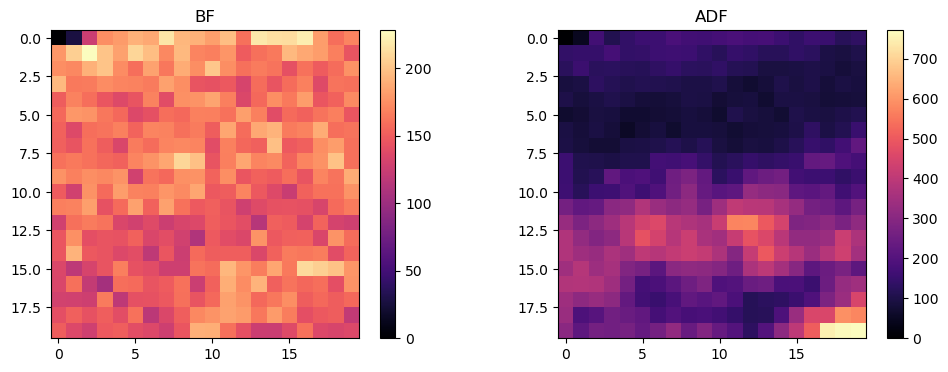

In [112]:
bf_img = results["virtual_images"]["BF"]
adf_img = results["virtual_images"]["ADF"]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(bf_img, cmap="magma"); plt.title("BF"); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(adf_img, cmap="magma"); plt.title("ADF"); plt.colorbar()
plt.show()

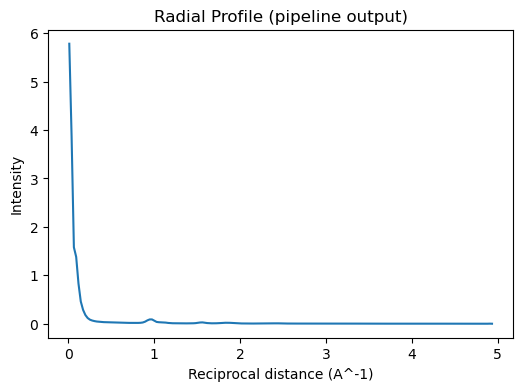

In [113]:
rad = results["radial_profile"]
plt.figure(figsize=(6,4))
plt.plot(rad["r_physical"], rad["intensity"])
plt.xlabel(f"Reciprocal distance ({rad['unit']})")
plt.ylabel("Intensity")
plt.title("Radial Profile (pipeline output)")
plt.show()

### Automatic calibration from pipeline

In [114]:
results = run_pipeline(
    data4d=data4d,     # Si–Au
    detectors=detectors,
    dc=dc,             # has Q_pixel_size
    manual_calibration=None,
    compute_radial=True
)

Axis order used: [0, 1, 2, 3]
Normalized shape: (20, 20, 256, 256)
dc.calibration: Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.026740015
             R_pixel_size:    0.0020393706
             Q_pixel_units:   A^-1
             R_pixel_units:   µm
             QR_flip:         False
)
Calibration: 0.026740015 A^-1 (source: dc.Q_pixel_size/Q_pixel_units)


### Demonstrating that the pipeline allows manual calibration support when needed

In [115]:
manual_calibration = {
    "reciprocal_scale": 0.02,   # example value
    "reciprocal_unit": "A^-1",
}

results_manual = run_pipeline(
    data4d=data4d,     # still Si–Au data
    detectors=detectors,
    dc=None,           # simulate missing calibration
    manual_calibration=manual_calibration,
    compute_radial=False
)

Axis order used: [0, 1, 2, 3]
Normalized shape: (20, 20, 256, 256)
Calibration: 0.02 A^-1 (source: manual)


# Task 4. Apply Pipeline to Si/SiGe dataset

In [116]:
# Load 4D-STEM data
import py4DSTEM

filepath_sige = "Si-SiGe.dm4"
dc_sige = py4DSTEM.io.import_file(filepath_sige)

print("Dataset successfully loaded!")

Dataset successfully loaded!


In [117]:
# Inspect 4D-STEM data upon import
print(type(dc_sige))
print("Dataset shape:", dc_sige.data.shape)
print(dc_sige.calibration)

<class 'py4DSTEM.datacube.datacube.DataCube'>
Dataset shape: (480, 448, 77, 17)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             QR_flip:         False
)


In [118]:
# Extract raw 4D array
data4d_sige = dc_sige.data

# Confirm dimensions
sx, sy, kx, ky = data4d_sige.shape
print("Scan shape:", (sx, sy))
print("Diffraction pattern shape:", (kx, ky))

Scan shape: (480, 448)
Diffraction pattern shape: (77, 17)


In [119]:
data4d_sige_norm, axis_order = normalize_datacube_axes(data4d_sige)
print("Axis order used:", axis_order)
print("Normalized shape:", data4d_sige_norm.shape)  # should become (scan_x, scan_y, ky, kx)

Axis order used: [2, 3, 0, 1]
Normalized shape: (77, 17, 480, 448)


In [120]:
avg_dp_sige = np.mean(data4d_sige_norm, axis=(0, 1))

beam_cx_sige, beam_cy_sige = estimate_beam_center_com(avg_dp_sige)
print("Si/SiGe beam center:", (beam_cx_sige, beam_cy_sige))

Si/SiGe beam center: (223, 239)


In [121]:
from scipy.ndimage import shift as ndi_shift

def recenter_datacube_by_com(data4d_norm, ref_center=None, max_shift=15):
    sx, sy, ny, nx = data4d_norm.shape
    recentered = np.empty_like(data4d_norm)

    # reference center = CoM of average DP (good default)
    if ref_center is None:
        avg_dp = np.mean(data4d_norm, axis=(0, 1))
        ref_center = estimate_beam_center_com(avg_dp)

    ref_cx, ref_cy = ref_center

    for i in range(sx):
        for j in range(sy):
            dp = data4d_norm[i, j]
            cx, cy = center_of_mass(dp)  # your guarded CoM function is best
            if not np.isfinite(cx) or not np.isfinite(cy):
                recentered[i, j] = dp
                continue

            dx = ref_cx - cx
            dy = ref_cy - cy

            # prevent insane shifts if something is off
            dx = np.clip(dx, -max_shift, max_shift)
            dy = np.clip(dy, -max_shift, max_shift)

            recentered[i, j] = ndi_shift(dp, shift=(dy, dx), order=1, mode="nearest")

    return recentered, ref_center

data4d_sige_centered, ref_center = recenter_datacube_by_com(data4d_sige_norm, ref_center=(beam_cx_sige, beam_cy_sige))
print("Recentering reference center:", ref_center)

Recentering reference center: (223, 239)


In [122]:
# Choose which 4D array to use (centered is better)
data_for_pipeline = data4d_sige_centered  # or data4d_sige_norm if you skipped recentering

sx, sy, ny, nx = data_for_pipeline.shape
dp_shape = (ny, nx)

# Use the Si/SiGe beam center (or ref_center if you recentered)
beam_center = ref_center if "ref_center" in globals() else (beam_cx_sige, beam_cy_sige)

X, Y, R = make_reciprocal_grid(dp_shape, beam_center)

# Reuse your existing radii (adjust later if needed)
bf_radius = 10
adf_inner = 25
adf_outer = 60

bf_mask = (R <= bf_radius).astype(float)
adf_mask = ((R >= adf_inner) & (R <= adf_outer)).astype(float)

validate_detector(bf_mask, dp_shape)
validate_detector(adf_mask, dp_shape)

detectors = {"BF": bf_mask, "ADF": adf_mask}

In [123]:
# Choose which 4D array to use (centered is better)
data_for_pipeline = data4d_sige_centered  # or data4d_sige_norm if you skipped recentering

sx, sy, ny, nx = data_for_pipeline.shape
dp_shape = (ny, nx)

# Use the Si/SiGe beam center (or ref_center if you recentered)
beam_center = ref_center if "ref_center" in globals() else (beam_cx_sige, beam_cy_sige)

X, Y, R = make_reciprocal_grid(dp_shape, beam_center)

# Reuse your existing radii (adjust later if needed)
bf_radius = 10
adf_inner = 25
adf_outer = 60

bf_mask = (R <= bf_radius).astype(float)
adf_mask = ((R >= adf_inner) & (R <= adf_outer)).astype(float)

validate_detector(bf_mask, dp_shape)
validate_detector(adf_mask, dp_shape)

detectors = {"BF": bf_mask, "ADF": adf_mask}

In [124]:
manual_calibration = {
    "reciprocal_scale": 1.0,      # leave as pixels for now
    "reciprocal_unit": "pixels",
    "scan_step_nm": None,         # IMPORTANT for scale bar (we’ll set this next)
}

results_sige = run_pipeline(
    data4d=data_for_pipeline,
    detectors=detectors,
    dc=dc_sige,                   # ok even if empty
    manual_calibration=manual_calibration,
    compute_radial=False,         # not needed for Task 4 images
    verbose=True
)

Axis order used: [0, 1, 2, 3]
Normalized shape: (77, 17, 480, 448)
dc.calibration: Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             QR_flip:         False
)
Calibration: 1.0 pixels (source: dc.Q_pixel_size/Q_pixel_units)


In [125]:
scan_step_nm = 1.0  # <-- REPLACE with your known value (nm per scan pixel)

In [126]:
import matplotlib.pyplot as plt

def add_scale_bar(ax, scan_step_nm, length_nm=50, location="lower right", pad=0.05, linewidth=4):
    """
    Adds a scale bar of length_nm (in nm) to an image plot.
    scan_step_nm = nm per pixel in the scan grid.
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    length_px = length_nm / scan_step_nm

    # anchor in axes fraction
    if location == "lower right":
        x0 = xlim[1] - (xlim[1]-xlim[0]) * pad - length_px
        y0 = ylim[0] + (ylim[1]-ylim[0]) * pad
    elif location == "lower left":
        x0 = xlim[0] + (xlim[1]-xlim[0]) * pad
        y0 = ylim[0] + (ylim[1]-ylim[0]) * pad
    else:
        x0 = xlim[0] + (xlim[1]-xlim[0]) * pad
        y0 = ylim[0] + (ylim[1]-ylim[0]) * pad

    ax.plot([x0, x0 + length_px], [y0, y0], solid_capstyle='butt', linewidth=linewidth)
    ax.text(x0 + length_px/2, y0 + (ylim[1]-ylim[0]) * 0.03,
            f"{length_nm} nm", ha="center", va="bottom", fontsize=10)

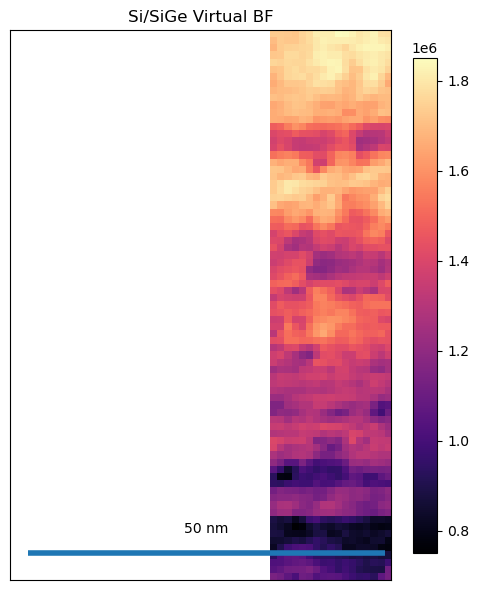

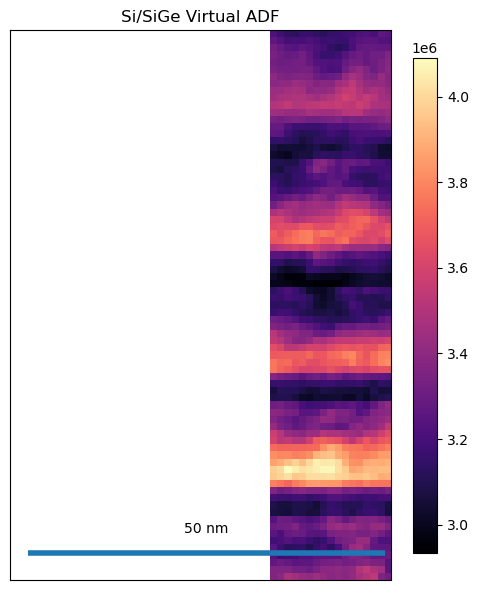

In [127]:
bf_img = results_sige["virtual_images"]["BF"]
adf_img = results_sige["virtual_images"]["ADF"]

# BF
plt.figure(figsize=(6,6))
ax = plt.gca()
im = ax.imshow(bf_img, cmap="magma")
ax.set_title("Si/SiGe Virtual BF")
ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(im, fraction=0.046, pad=0.04)
add_scale_bar(ax, scan_step_nm=scan_step_nm, length_nm=50)
plt.tight_layout()
plt.savefig("SiSiGe_BF.png", dpi=300)
plt.show()

# ADF
plt.figure(figsize=(6,6))
ax = plt.gca()
im = ax.imshow(adf_img, cmap="magma")
ax.set_title("Si/SiGe Virtual ADF")
ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(im, fraction=0.046, pad=0.04)
add_scale_bar(ax, scan_step_nm=scan_step_nm, length_nm=50)
plt.tight_layout()
plt.savefig("SiSiGe_ADF.png", dpi=300)
plt.show()